In [0]:
import numpy as np
import pylab as plt
import scipy as sp
from scipy import linalg as la
import scipy.stats as stats
%matplotlib inline

In [0]:
figsize = (8,8)

In [0]:
def PSD(n,sqrt=False):
  """
  compute random positive semidefinite matrix

  input:
    n - int - dimension of matrix
    (optional)
    sqrt - bool - whether to return S such that Q = np.dot( S.T, S)

  output:
    Q - n x n - Q = Q^T,  spec Q \subset R^+
  """
  H = np.random.randn( n, n )
  d,u = np.linalg.eig( H + H.T )
  S = np.dot( u, np.dot( np.diag( np.sqrt( d*np.sign( d ) ) ), u.T ) )
  if sqrt:
    return np.dot( S.T, S ), S
  else:
    return np.dot( S.T, S )

def CT(n,margin=1e-1):
  """
  compute random stable system matrix for continuous-time linear system
    dx/dt = A x
  
  input:
    n - int - dimension of state
    
  output:
    A - n x n - spec A \subset C_o^- (open left-half complex plane)  
  """
  d,u = la.eig( np.random.randn( n, n ) )
  d.real = -np.abs(d.real)-margin
  A = np.dot( u, np.dot( np.diag(d), u.T ) )
  return A.real

def DT(n,margin=1e-1):
  """
  compute random stable system matrix for discrete-time linear system
    x^+ = A x
  
  input:
    n - int - dimension of state
    
  output:
    A - n x n - |spec A| < 1
  """
  d,u = la.eig( np.random.randn( n, n ) )
  d /= (np.abs(d).max()+margin)
  A = np.dot( u, np.dot( np.diag(d), u.T ) )
  return A.real

def forward(f,x,fx,d):
    """
    df = forward()  compute forward difference 

    df = (f(x+d) - fx)/np.linalg.norm(d)
    """
    return (f(x+d) - fx)/np.linalg.norm(d)

def D(f, x, fx=None, d=1e-6, D=None, diff=forward):
    """
    Numerically approximate derivative of f at x

    Inputs:
    f : R^n --> R^m
    x - n vector
    d - scalar or (1 x n) - displacement in each coordinate
    (optional)
    fx - m vector - f(x)
    D - k x n - directions to differentiate (assumes D.T D invertible)
    diff - func - numerical differencing method

    Outputs:
    Df - m x n - Jacobian of f at x
    """
    if fx is None:
        fx = f(x)
    if D is None:
        J = map(lambda dd : diff(f,x,fx,dd), list(d*np.identity(len(x))))
    else:
        J = map(lambda dd : diff(f,x,fx,dd), list(D))
    return J

Consider the linear-quadratic regulation (LQR) problem for the discrete-time linear time-invariant system
$$x^+ = A x + B u$$
with infinite-horizon cost
$$J(x,u) = \frac{1}{2}\sum_{t=0}^\infty x^T Q x + u^T R u \ dt$$
where  $Q = Q^T > 0$ and $R = R^T > 0$.  We know that the optimal policy is linear in state, 
$$u = - K x,$$
where $K = (R + B^T Y B)^{-1} (B^T Y A)$ and $Y$ satisfies the discrete algebraic Riccati equation
$$Y = A^T Y A - (A^T Y B)(R + B^T Y B)^{-1}(B^T Y A) + Q.$$

In [0]:
np.random.seed(49)

In [0]:
n,m = 1,1 # dimension of continuous state, input
Q,R = PSD(n),PSD(m) # cost of state, input
A,B = DT(n),np.random.randn(n,m) # choose A stable to make our life easy
print A,B,Q,R

[[ 0.7520394]] [[ 0.54217157]] [[ 1.31836958]] [[ 1.41524405]]


In [0]:
Y = la.solve_discrete_are(A,B,Q,R)
# optimal policy
K = np.dot( la.inv(R + np.dot( B.T, np.dot(Y, B))), 
            np.dot( B.T, np.dot( Y, A ) ) )
assert np.all(np.abs(la.eigvals(A - np.dot(B,K))) < 1),"u = - K x stabilizes x^+ = A x + B u"
# suboptimal policy
L = K + 1e-1*np.abs(K).max()*np.random.rand(m,n) # don't stray too far from optimal
assert np.all(np.abs(la.eigvals(A - np.dot(B,L))) < 1),"u = - L x stabilizes x^+ = A x + B u"

if we choose a Gaussian policy 
$$u \sim \mathcal{N}(\mu, V)$$
(or, equivalently, a deterministic policy $u = \mu$ and a Gaussian disturbance $v \sim \mathcal{N}(0, V)$)
then the state distribution after one step is also Gaussian:
$$x^+ \sim \mathcal{N}(Ax + B\mu, B V B^T).$$

In [0]:
V = PSD(m)
v = stats.multivariate_normal(mean=np.zeros(m),cov=V)

Similarly, if the state distribution starts out Gaussian, 
$$x \sim \mathcal{N}(\xi, \Sigma),$$
and we apply zero input but add a state disturbance with zero mean and covariance $W$, then (so long as the disturbance is uncorrelated with the state) the state distribution after one step is 
$$x^+ \sim \mathcal{N}(A\xi, A\Sigma A^T + W),$$
i.e. the covariance gets updated via
$$\Sigma^+ = A\Sigma A^T + W.$$
Since $A$ is stable, so long as $W$ is constant, this iteration will converge to a solution of the Lyapunov equation
$$S = A S A^T + W.$$
Also, since $A$ is stable, the steady-state mean is zero, thus we can determine the steady-state distribution in closed-form:
$$\lim_{t\rightarrow\infty} x(t) \sim \mathcal{N}(0, S).$$

In [0]:
W = PSD(n) + np.dot(B, np.dot(V, B.T))
S = la.solve_discrete_lyapunov(A,W)
assert np.allclose( S, np.dot(A, np.dot( S, A.T )) + W )

In [0]:
s = stats.multivariate_normal(mean=np.zeros(n),cov=S)
w = stats.multivariate_normal(mean=np.zeros(n),cov=W)
x_ = stats.multivariate_normal(mean=np.zeros(n),cov=W)

We'll use this fact to build a finite MDP $(X,U,P,C)$:

* $X$ is a finite set of $N$ *states*
* $U$ is a finite set of $M$ *actions*
* $P:X\times U\rightarrow \Delta(X)$ is transition probability
* $C:X\times U\times X\rightarrow \mathbb{R}$ is cost 

where $\Delta(S) = \{p\in[0,1]^S : \sum_{s\in S} p(s) = 1\}$ is the set of probability distributions over the discrete set $S$.

In [0]:
N,M = 1000,1 # number of discrete states, actions
X,U = 15*2.*(np.random.rand(N,n)-.5),15*2*(np.random.rand(M,m)-.5) # discrete states, actions
X[0],U[0] = 0,0 # always include the origin and zero input
# TODO add meshgrid
# note that X & U can be any iterable
# the choice above ensures each element is also a vector, i.e. a continuous state
P = np.nan*np.zeros((N,M,N))
C = np.nan*np.zeros((N,M,N))
# loop over initial discrete state
for x_i,x in enumerate(X):
  # loop over discrete actions
  for u_i,u in enumerate(U):
    # evaluate Gaussian PDF with mean A x + B u, covariance B V B.T
    P[x_i,u_i] = x_.pdf(X - ( np.dot( x, A.T ) + np.dot( u, B.T ) ))
    
    # generally need to loop over next discrete state
    #for _x_i,_x in enumerate(X):
    #  C[x_i,u_i,_x_i] = .5 * ( np.dot( np.dot(x, Q), x)
    #                          +np.dot( np.dot(u, R), u) )
    # but in this case cost doesn't depend on next state, so we can broadcast a scalar
    C[x_i,u_i] = .5 * ( np.dot( np.dot(x, Q), x)
                     + np.dot( np.dot(u, R), u) )
P = P / P.sum(axis=2)[...,np.newaxis] # renormalize probabilities
assert not np.any(np.isnan(P)),"all probabilities defined"
assert not np.any(np.isnan(C)),"all costs defined"

How do we know the MDP is correct?  We could check that the steady-state distributions match.  Let's apply zero input and construct the stochastic matrix $\Gamma : X \rightarrow \Delta(X)$ by
$$\forall x,x^+\in X : \Gamma(x)(x^+) = \sum_{u\in U} \pi(x)(u) P(x,u)(x^+)$$
and treating $p$ as a row vector, we can iterate $p^+ = p \Gamma$ until convergence.

However, knowing that $\Gamma$ is a right-stochastic matrix (rows sum to 1) and assuming the MDP is *irreducible*, the unique steady-state distribution is the left eigenvector associated with the unity eigenvalue.

In [0]:
pi = np.zeros((N,M)); pi[:,0] = 1. # U[0] == 0

G = np.zeros((N,N))
#for x_i,x in enumerate(X):
#    for _x_i,_x in enumerate(X):
#        G[x_i,_x_i] = np.sum([pi[x_i,u_i] * P[x_i,u_i,_x_i] for u_i,u in enumerate(U)])
G = np.sum(pi[...,np.newaxis]*P,axis=1)
assert np.allclose(np.sum(G,axis=1),1.)

e,El,Er = la.eig(G,left=True)
assert np.allclose(np.dot(El.T,G), (e*El).T), "rows of El.T are left eigenvectors of G"
p = El.T[np.argmax(np.abs(e))]
assert np.allclose(np.dot(p,G), p), "p is a stationary distribution"
p /= p.sum() # p must be normalized to become a probability distribution
assert np.allclose(p.imag,0.), "p is a real vector"
p = p.real # plotting commands will complain about complex numbers even if np.allclose(p.imag, 0.)

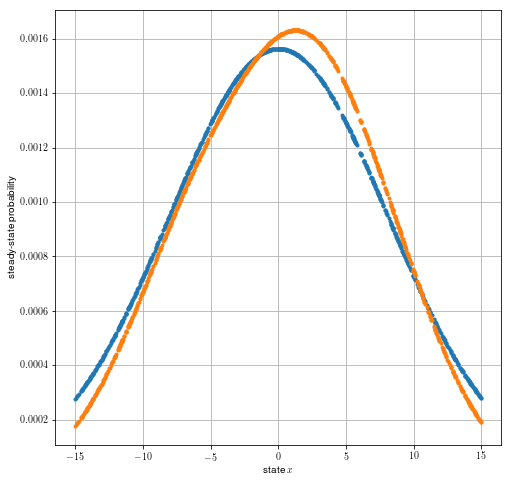

In [0]:
fig = plt.figure(figsize=figsize)

ax = plt.subplot(1,1,1); ax.grid('on')
ax.plot(X.flatten(),s.pdf(X)/s.pdf(X).sum(),'.')
ax.plot(X.flatten(),p,'.')
ax.set_ylabel('steady-state probability')
ax.set_xlabel('state $x$')

Now we'll use fewer discrete states so we can have more actions

In [0]:
N,M = 100,50 # number of discrete states, actions
X,U = 10*np.random.randn(N,n),10*np.random.randn(M,m) # discrete states, actions
#X,U = 15*2.*(np.random.rand(N,n)-.5),15*2*(np.random.randn(M,m)-.5) # discrete states, actions
X[0],U[0] = 0,0 # always include the origin and zero input
# TODO add meshgrid
#X,U = np.linspace(-1,1,N)[:,np.newaxis],np.linspace(-.1,.1,M)[:,np.newaxis]
# note that X & U can be any iterable
# the choice above ensures each element is also a vector, i.e. a continuous state
P = np.nan*np.zeros((N,M,N))
C = np.nan*np.zeros((N,M,N))
# loop over initial discrete state
for x_i,x in enumerate(X):
  # loop over discrete actions
  for u_i,u in enumerate(U):
    # evaluate Gaussian PDF with mean A x + B u, covariance B V B.T
    P[x_i,u_i] = x_.pdf(X - ( np.dot( x, A.T ) + np.dot( u, B.T ) ))
    
    # generally need to loop over next discrete state
    #for _x_i,_x in enumerate(X):
    #  C[x_i,u_i,_x_i] = .5 * ( np.dot( np.dot(x, Q), x)
    #                          +np.dot( np.dot(u, R), u) )
    # but in this case cost doesn't depend on next state, so we can broadcast a scalar
    C[x_i,u_i] = .5 * ( np.dot( np.dot(x, Q), x)
                     + np.dot( np.dot(u, R), u) )
P = P / P.sum(axis=2)[...,np.newaxis] # renormalize probabilities
assert not np.any(np.isnan(P)),"all probabilities defined"
assert not np.any(np.isnan(C)),"all costs defined"

Let us now consider the problem of minimizing the infinite-horizon discounted cost
$$J = \sum_{t=0}^\infty \gamma^t c_t,$$
where $\gamma\in(0,1]$ is a *discount factor* and $c_t = C(x_t,u_t)$ is the cost at time $t$.

In the un-discounted case, $g = 1$.

Discount factor $\gamma = 1$ corresponds exactly to LQR; unfortunately, policy iteration won't converge when $\gamma = 1$!

In [0]:
g = 1

I would have thought $\gamma$ would need to be very close to 1, e.g. $0.999$, but this doesn't appear to be the case -- even $\gamma = 0.5$ gives very similar results in the scalar case.

In [0]:
g = 0.999

In [0]:
g = np.random.rand()

In [0]:
g = .75

In [0]:
g = .5

In [0]:
# policy
pi = np.abs(np.random.randn(N,M)); pi = pi / np.sum(pi,axis=1)[:,np.newaxis]
assert np.allclose(np.sum(pi,axis=1),1.)

def policy_evaluation(X,U,P,C,g,pi):
    b = np.asarray([ np.sum([[pi[xi,mu] * P[xi,mu,x] * C[xi,mu,x] 
                          for x in X] for mu in U]) for xi in X])
    I = np.identity(N)
    L = I - np.asarray([ np.asarray([ np.sum([g * pi[xi,mu] * P[xi,mu,x] 
                                              for mu in U]) for x in X]) for xi in X])
    # V satisfies Bellman equation
    V = np.dot(b,la.inv(L).T)
    assert np.allclose(V, [np.sum([[pi[xi,mu] * P[xi,mu,x] * (C[xi,mu,x] + g*V[x]) 
                                for x in X] for mu in U]) for xi in X])
    return V

def policy_improvement(X,U,P,C,g,V):
    N = len(X); M = len(U)
    pi = np.zeros((N,M))
    for xi in X:
        u = np.argmin([np.sum([P[xi,mu,x]*(C[xi,mu,x] + g*V[x]) for x in X]) for mu in U])
        #assert len(u) == 1
        pi[xi,u] = 1.
    return pi

def policy_iteration(X,U,P,C,g,pi0):
    pi_ = [pi0]
    V_  = []
    while len(V_) < 2 or not(np.allclose(V_[-1],V_[-2])):
        pi = pi_[-1]
        V  = policy_evaluation(X,U,P,C,g,pi)
        _pi = policy_improvement(X,U,P,C,g,V)
        pi_.append(_pi)
        V_.append(V)
    return pi_,V_

pi_PI,V_PI = policy_iteration(range(N),range(M),P,C,g,pi)
print 'done!  %d iterations' % len(V_PI)

done!  4 iterations


# Q:  why is there baseline shift in the value?

Policy iteration over-estimates the value by an additive constant.  Although adding a constant to the (optimal) value doesn't change the (optimal) policy, I don't see exactly why this occurs -- since the value can be computed by inverting a matrix, it should be unique; therefore this shift must arise from either the choice of discount factor $\gamma$ or in the creation of the MDP.

In [0]:
V_PI[-1][0]

20.23464613347879

In [0]:
.5*np.dot( np.dot(X[0],Y), X[0] )

0.0

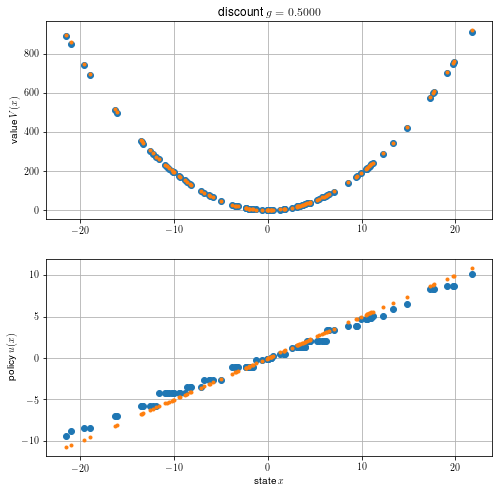

In [0]:
fig = plt.figure(figsize=figsize)

ax = plt.subplot(2,1,1); ax.grid('on')
ax.plot(X.flatten(),V_PI[-1]-V_PI[-1][0],'o')
ax.plot(X.flatten(),.5*np.diag(np.dot( np.dot(X,Y), X.T ))
                   -.5*np.dot( np.dot(X[0],Y), X[0] ),'.')
ax.set_ylabel('value $V(x)$')
ax.set_title('discount $g = %0.4f$' % g)

ax = plt.subplot(2,1,2); ax.grid('on')
ax.plot(X.flatten(),U[np.argmax(pi_PI[-1],axis=1)],'o')
ax.plot(X.flatten(),-np.dot(K,X.T).flatten(),'.')
ax.set_ylabel('policy $u(x)$')
ax.set_xlabel('state $x$')

Note that the optimal policy we've selected is deterministic:

deterministic policy? True


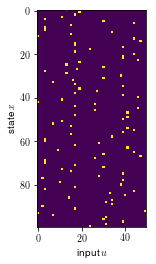

In [0]:
print "deterministic policy?", np.allclose(np.sum(pi_PI[-1] > 0,axis=1),1)
plt.imshow(pi_PI[-1],interpolation='nearest')
plt.xlabel(r'input $u$')
plt.ylabel(r'state $x$')

# policy gradient algorithms

## REINFORCE

Given a trajectory $\tau:[1,T]\rightarrow X\times U$ where $\tau(t) = \tau_t = (x(t), u(t)) = (x_t, u_t)$ denotes a (state, input) tuple and $c_t = c(x_t,u_t)$ denotes the cost at time $t$, let 

$$\sum_{s\ge t}\gamma^{s-t} c(x_s,u_s)$$

denote the total discounted cost from time $t$ onward (to infinity in theory, to the length of the trajectory in practice), where $\gamma\in(0,1)$ is a discount factor.

Suppose the stochastic policy is parameterized as $\pi:\Theta\times X\rightarrow\Delta(U)$, and that $\pi$ is differentiable with respect to $\theta\in\Theta$; note that we can make sense of differentiability even when $U$ is a finite set since the codomain of $\pi$ is the set of probability distributions over $U$, which is continuous even when $U$ is discrete.

Given a parameter choice $\theta\in\Theta$, we'll define $\pi_\theta:X\times U\rightarrow [0,1]$ by $\pi_\theta(x,u) = \pi(\theta,x)(u)$, i.e. $\pi_\theta(x,u)$ evaluates the probability of input $u$ using the distribution $\pi(\theta,x)$.  Similarly, we'll define $J(\theta)$ as the expected infinite-horizon discounted cost when policy $\pi_\theta$ is used, and $Q(\theta)$ as the corresponding state-action value.

Then we'll determine the parameter update direction by approximating the derivative $D_\theta J(\theta)$ using the [Policy Gradient Theorem](https://paperpile.com/shared/MoBHhv):

$$D_\theta J(\theta) = E_{\pi_\theta}\left[ D_\theta\log\pi(\theta) Q(\theta) \right]$$

where the expectation is over trajectories generated by $\pi_\theta$.

In [0]:
def sample(pdf):
    pdf = np.asarray(pdf)
    return np.argmax(np.cumsum(pdf,axis=1) > np.random.rand(pdf.shape[0])[:,np.newaxis],axis=1)

def traces(T,N,X,U,P,C,pi):
    X_ = np.zeros((T+1,N),dtype=np.int) 
    U_ = np.zeros((T,N),dtype=np.int) 
    X_[0] = np.random.choice(range(len(X)),N)
    C_ = np.nan*np.zeros((T,N))
    for t in range(0,T):
        # sample from pi conditioned on state x to obtain input u
        U_[t] = sample(pi[X_[t]])
        # sample from P conditioned on state x and input u to obtain next state x_
        X_[t+1] = sample([P[x,u] for x,u in zip(X_[t],U_[t])])
        # evaluate cost of (x,u,x_)
        C_[t] = [C[x,u,x_] for x,u,x_ in zip(X_[t],U_[t],X_[t+1])]
    return U_,X_[:-1],C_

# WARNING:  these seem to work only for n,m = 1 !

In [0]:
def pi_normal(K,x,u,S):
    d = u - np.dot(x,K.T)
    # vectorized Sigma-weighted inner products -- the following are equivalent:
    #assert np.allclose(np.diag(np.dot( d, np.dot( la.inv(S), d.T )) ), 
    #                   np.einsum('ij,jk,ik->i',d,la.inv(S),d))
    # einsum is more efficient in memory and computation
    return ( np.exp( - np.einsum('ij,jk,ik->i',d,la.inv(S),d) / 2 ) 
             / np.sqrt( ( 2 * np.pi ** x.shape[1] ) * la.det(S)) )

def Dlogpi_normal(K,x,u,S):
    d = u - np.dot(x,K.T)
    return np.einsum('ij,jk,ik->i',x,la.inv(S),d)

Following [Sergey's notes](http://rll.berkeley.edu/deeprlcourse/f17docs/lecture_4_policy_gradient.pdf), we use the following (Monte Carlo) approximation:
$$D_\theta J(\theta) = E_{\pi_\theta}\left[ D_\theta\log\pi(\theta) Q(\theta) \right] \approx \frac{1}{N}\sum_n\left[\sum_t D_\theta\log\pi_\theta(\tau(t,n))\right] \left[\sum_t \gamma^t c(\tau(t,n)) \right]$$
where $\tau:[1,T]\times[1,N]\rightarrow X\times U$ is a collection of trajectories generated with policy $\pi_\theta$.

This is a simple average of the REINFORCE formula from [David Silver's policy gradient lecture notes](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf).

We update in the opposite direction of the estimated gradient (since we're minimizing cost):

$$\theta^+ = \theta - \alpha D_\theta J(\theta)$$

In [0]:
import warnings
warnings.filterwarnings("error")

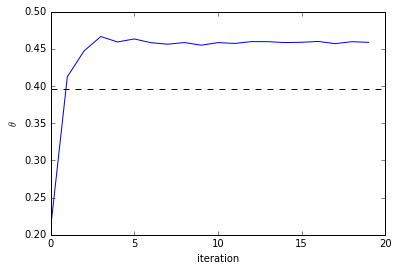

In [0]:
T,L = 10,100

# to obtain an MDP policy, we need to evaluate pi_normal at all pairs (X,U)
# obviously this could be done with a nested loop, but we can cleverly vectorize:
_X = np.rollaxis(X[...,np.newaxis] * np.ones((1,1,M)),2,1).reshape(N*M,n)
_U = np.rollaxis(U[...,np.newaxis] * np.ones((1,1,N)),2,0).reshape(N*M,m)

theta_PG = [np.asarray(np.random.randn())]
#theta_PG = [K[0,0]]
pi_PG = [pi_normal(theta_PG[-1],_X,_U,V).reshape(N,M)]
V_PG = []
for a in 1e-6 / np.arange(1,20):
    U_,X_,C_ = traces(T,L,X,U,P,C,pi_PG[-1])
    DJ = ( Dlogpi_normal(K,X[X_.reshape(X_.size)],U[U_.reshape(U_.size)],V).reshape(X_.shape).sum(axis=0)
           * (C_ * (g**np.arange(T))[:,np.newaxis]).sum(axis=0) )
    theta_PG.append(theta_PG[-1] - a * DJ.mean())
    pi_PG.append(pi_normal(theta_PG[-1],_X,_U,V).reshape(N,M))
    V_PG.append(-policy_evaluation(range(N),range(M),P,C,g,-pi_PG[-1]))
    
theta_PG = np.asarray(theta_PG)
pi_PG = np.asarray(pi_PG)

plt.plot(theta_PG)
xlim = plt.xlim()
plt.plot(xlim,K[0,0]*np.ones(2),'k--')
plt.xlabel('iteration')
plt.ylabel(r'$\theta$')

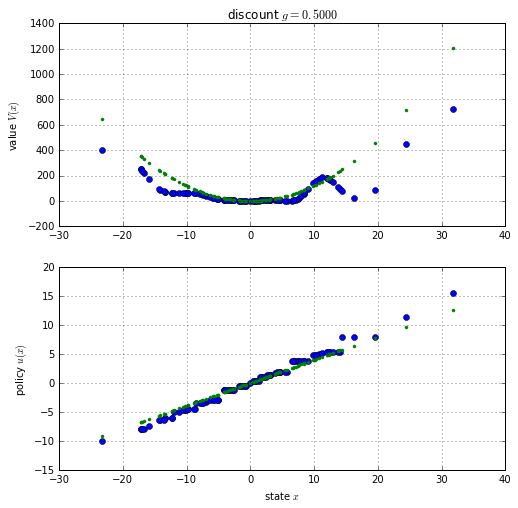

In [0]:
fig = plt.figure(figsize=figsize)

ax = plt.subplot(2,1,1); ax.grid('on')
ax.plot(X.flatten(),V_PG[-1]-V_PG[-1][0],'o')
ax.plot(X.flatten(),.5*np.diag(np.dot( np.dot(X,Y), X.T ))
                   -.5*np.dot( np.dot(X[0],Y), X[0] ),'.')
ax.set_ylabel('value $V(x)$')
ax.set_title('discount $g = %0.4f$' % g)

ax = plt.subplot(2,1,2); ax.grid('on')
ax.plot(X.flatten(),U[np.argmax(pi_PG[-1],axis=1)],'o')
ax.plot(X.flatten(),np.dot(K,X.T).flatten(),'.')
ax.set_ylabel('policy $u(x)$')
ax.set_xlabel('state $x$')

# Q:  why do these work only for n,m = 1 ?

In [0]:
n = 1
m = 1

l = 2
K = np.random.randn(m,n)
x = np.random.randn(l,n)
u = np.random.randn(l,m)
S = PSD(m)
print x
print u
print S

#print pi_normal(K,x,u,S)
#print np.exp( np.diag(- np.dot( u - K*x, np.dot( la.inv(S), u - K*x )) ) / 2 ) / np.sqrt(2*np.pi*la.det(S))
norm1 = pi_normal(K,x,u,S)
norm2 = [stats.multivariate_normal(np.dot(xx,K.T),S).pdf(uu) for xx,uu in zip(x,u)]
print norm1
print norm2
print "normal distribution correct?", np.allclose(norm1,norm2)

ds = np.logspace(-10,0,11)
np.asarray([D(lambda K : pi_normal(K,x,u,S),K,d=d) for d in ds]).flatten()

print D(lambda K : np.log(pi_normal(K,x,u,S)),K)
print Dlogpi_normal(K,x,u,S)
print "derivative of log of distribution correct?", np.allclose(D(lambda K : np.log(pi_normal(K,x,u,S)),K), Dlogpi_normal(K,x,u,S))

[[ 1.13925012]
 [ 1.62288655]]
[[ 0.91650481]
 [ 1.20388235]]
[[ 2.76970277]]
[ 0.22582926  0.21845278]
[0.22582925852690094, 0.21845277794998985]
normal distribution correct? True
[array([ 0.23647545,  0.42028111])]
[ 0.23647569  0.42028158]
derivative of log of distribution correct? True


In [0]:
%pdb

Automatic pdb calling has been turned ON
